In [1]:
import tensorflow as tf
import keras
from keras import *
from keras.layers import *
from keras.models import *
import keras.backend as K
import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

from scipy.interpolate import griddata
import time
# from google.colab import files
# files.upload()
from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

/home/ritvik/anaconda3/envs/cfd_ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ritvik/anaconda3/envs/cfd_ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ritvik/anaconda3/envs/cfd_ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ritvik/anaconda3/envs/cfd_ml/lib/python3

In [2]:
def custom_loss_wrapper(Re):
#     input_tensor = concatenate([t, x, y], 1)
    def gradient_calc(Re):
        
        uvp = model.output
        u = uvp[:,0:1]
        v = uvp[:,1:2]
        p = uvp[:,2:3]
        eta = uvp[:,3:4]
#         print(u)
        
        u_t,u_x,u_y = K.gradients(u,model.input)
        v_t,v_x,v_y = K.gradients(v,model.input)
        p_t,p_x,p_y = K.gradients(p,model.input)
        eta_t,eta_x,eta_y = K.gradients(eta,model.input)
        
        u_xx = K.gradients(u_x,model.input[1])[0]
        u_yy = K.gradients(u_y,model.input[2])[0]
        v_xx = K.gradients(v_x,model.input[1])[0]
        v_yy = K.gradients(v_y,model.input[2])[0]
        eta_tt = K.gradients(eta_t,model.input[0])[0]
        
#         print((u_xx)+(u_yy))
        
        eq1 = u_t + (u*u_x + v*u_y) + p_x - (1.0/Re)*(u_xx + u_yy)
        eq2 = v_t + (u*v_x + v*v_y) + p_y - (1.0/Re)*(v_xx + v_yy) + eta_tt
        eq3 = u_x + v_y
        
        loss = K.mean(tf.square(eq1)) + K.mean(tf.square(eq2)) + K.mean(tf.square(eq3))
        
#         print((u_xx))
        return loss

    def custom_loss(y_true, y_pred):
        navier_loss = gradient_calc(Re=Re)
#         navier_loss = net_VIV(input_tensor,y_pred,Re=1000)
        return tf.reduce_mean(tf.square(y_true - y_pred)) + navier_loss
    return custom_loss

# model.compile(loss={'out_eta': 'mean_squared_error', 'out_uvp': custom_loss_wrapper(model.layers[3])}, optimizer='adam', metrics=['accuracy','mean_squared_error'])
# model.compile(loss=custom_loss_wrapper(Re=1000), optimizer='adam', metrics=['accuracy','mean_squared_error'])

In [4]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

# tf_config = some_custom_config
sess = tf.Session()
graph = tf.get_default_graph()
set_session(sess)

In [5]:
model = load_model("trained_models/medium_foil_model4.h5",compile=False)
model.compile(loss=custom_loss_wrapper(Re=1000), optimizer='adam', metrics=['mse'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           64          input_1[0][0]                    
____________________________________________________________________________________________

In [6]:
def load_data(filename = "final_translated_data.csv"):
    time_1 = time.time()
    data = pd.read_csv(filename)
    print("[INFO] Time taken = "+str(time.time()-time_1)+" seconds.")
    return data

In [7]:
def create_tensors(data):
    
    t_star = data['t'] # T x 1
    eta_star = data['eta'] # T x 1
    
    T = t_star.shape[0]
        
    X_star = data['x']
    Y_star = data['y']        
    U_star = data['u']
    V_star = data['v']
    P_star = data['p']

    t = t_star.to_numpy()
    eta = eta_star.to_numpy()
    
    # T = t_star.shape[0]
        
    x = X_star.to_numpy()
    y = Y_star.to_numpy()        
    u = U_star.to_numpy()
    v = V_star.to_numpy()
    p = P_star.to_numpy()
    
    ## clipping
    
    t = t.reshape((t.shape[0],1))
    x = x.reshape((x.shape[0],1))
    y = y.reshape((y.shape[0],1))
    u = u.reshape((u.shape[0],1))
    v = v.reshape((v.shape[0],1))
    p = p.reshape((p.shape[0],1))
    eta = eta.reshape((eta.shape[0],1))
    
    return t,x,y,u,v,p,eta

In [8]:
def plot_time_data(time_snap):
  time_data = data[data['t']==time_snap]
  x_snap = time_data["x"]
  y_snap = time_data["y"]
  plt.plot(x_snap, y_snap, 'bo',markersize=0.1,marker='o',scalex=3,scaley=3)
  plt.title("at time: "+str(time_snap)+" second")
  plt.show()

In [9]:
data = load_data(filename="data/final_translated_data_1_3.csv")
t_orig,x_orig,y_orig,u_orig,v_orig,p_orig,eta_orig = create_tensors(data)
t_orig.shape,x_orig.shape,y_orig.shape,u_orig.shape,v_orig.shape,p_orig.shape,eta_orig.shape

[INFO] Time taken = 6.121975421905518 seconds.


((3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1))

In [10]:
## Scaling the input
scale_vals = np.concatenate([t_orig,x_orig,y_orig,u_orig,v_orig,p_orig,eta_orig],1)
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(scale_vals)
scale_vals = scaler.transform(scale_vals)
scale_vals.shape
scaled_list = np.split(scale_vals,7,axis=1)

t = scaled_list[0]
x = scaled_list[1]
y = scaled_list[2]
u = scaled_list[3]
v = scaled_list[4]
p = scaled_list[5]
eta = scaled_list[6]

t.shape,x.shape,y.shape,u.shape,v.shape,p.shape,eta.shape

((3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1))

In [11]:
def scale(t,x,y,u,v,p,eta):
    scale_vals = np.concatenate([t,x,y,u,v,p,eta],1)
    scale_vals = scaler.transform(scale_vals)
    scaled_list = np.split(scale_vals,7,axis=1)
    
    t_scaled = scaled_list[0]
    x_scaled = scaled_list[1]
    y_scaled = scaled_list[2]
    u_scaled = scaled_list[3]
    v_scaled = scaled_list[4]
    p_scaled = scaled_list[5]
    eta_scaled = scaled_list[6]

    return t_scaled,x_scaled,y_scaled,u_scaled,v_scaled,p_scaled,eta_scaled

In [12]:
## Inv-scaling outputs
def de_scale(t_test,x_test,y_test,uvpEta_test):
    final_test = np.concatenate([t_test,x_test,y_test,uvpEta_test],1) 
#     print(final_test.shape)
    de_scale_vals = scaler.inverse_transform(final_test)
    # print(de_scale_vals.shape)
    scaled_list = np.split(de_scale_vals,7,axis=1)
    
    t_test_invSc = scaled_list[0]
    x_test_invSc = scaled_list[1]
    y_test_invSc = scaled_list[2]
    u_test_invSc = scaled_list[3]
    v_test_invSc = scaled_list[4]
    p_test_invSc = scaled_list[5]
    eta_test_invSc = scaled_list[6]
    
    return t_test_invSc,x_test_invSc,y_test_invSc,u_test_invSc,v_test_invSc,p_test_invSc,eta_test_invSc

In [13]:
def plot_solution(x_star, y_star, u_star, ax):

    nn = 200
    x = np.linspace(x_star.min(), x_star.max(), nn)
    y = np.linspace(y_star.min(), y_star.max(), nn)
    X, Y = np.meshgrid(x,y)

    X_star = np.concatenate((x_star, y_star), axis=1)

    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='linear', rescale=True)

    # h = ax.pcolor(X,Y,U_star, cmap = 'jet')

    h = ax.imshow(U_star, interpolation='nearest', cmap='jet', vmin=-2, vmax=2,
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()],
                  origin='lower', aspect='auto')

    return h

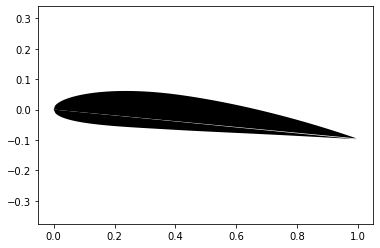

In [14]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np

#https://en.wikipedia.org/wiki/NACA_airfoil#Equation_for_a_cambered_4-digit_NACA_airfoil
def camber_line( x, m, p, c ):
    return np.where((x>=0)&(x<=(c*p)),
                    m * (x / np.power(p,2)) * (2.0 * p - (x / c)),
                    m * ((c - x) / np.power(1-p,2)) * (1.0 + (x / c) - 2.0 * p ))

def dyc_over_dx( x, m, p, c ):
    return np.where((x>=0)&(x<=(c*p)),
                    ((2.0 * m) / np.power(p,2)) * (p - x / c),
                    ((2.0 * m ) / np.power(1-p,2)) * (p - x / c ))

def thickness( x, t, c ):
    term1 =  0.2969 * (np.sqrt(x/c))
    term2 = -0.1260 * (x/c)
    term3 = -0.3516 * np.power(x/c,2)
    term4 =  0.2843 * np.power(x/c,3)
    term5 = -0.1015 * np.power(x/c,4)
    return 5 * t * c * (term1 + term2 + term3 + term4 + term5)

def naca4(x, m, p, t, c=1):
    dyc_dx = dyc_over_dx(x, m, p, c)
    th = np.arctan(dyc_dx)
    yt = thickness(x, t, c)
    yc = camber_line(x, m, p, c)  
    return ((x - yt*np.sin(th), yc + yt*np.cos(th)), 
            (x + yt*np.sin(th), yc - yt*np.cos(th)))


#naca2412 
m = 0.03
p = 0.4
t = 0.12
c = 1.0

x = np.linspace(0,1,200)
for item in naca4(x, m, p, t, c):
    x_val = item[0]*0.9953705935+item[1]*0.09611129781
    y_val = -item[0]*0.09611129781+item[1]*0.9953705935
    plt.fill(x_val, y_val, 'k')
#     plt.plot(x_val, y_val, 'k')

# plt.plot(x, camber_line(x, m, p, c), 'r')
plt.axis('equal')
plt.xlim((-0.05, 1.05))
plt.show()
# figure.set_size_inches(16,16,forward=True)


In [15]:
def plot_airfoil(ax):
    x = np.linspace(0,1,200)
    for item in naca4(x, m, p, t, c):
        x_val = item[0]*0.9953705935+item[1]*0.09611129781
        y_val = 0.05 -item[0]*0.09611129781+item[1]*0.9953705935
#         x_val=item[0]
#         v_val=item[1]
        ax.fill(x_val, y_val, 'w')
        ax.plot(x_val,y_val,'k')

def plot_figs(t_test,x_test,y_test,u_test,v_test,p_test,u_pred,v_pred,p_pred):
    
    fig, ax = newfig(3.0, 1.6)
    ax.axis('off')

    gs = gridspec.GridSpec(3, 2)
    gs.update(top=0.95, bottom=0.07, left=0.1, right=0.9, wspace=0.5, hspace=0.7)
        
    ########      Exact u(t,x,y)     ###########     
    ax = plt.subplot(gs[0:1, 0])
    h = plot_solution(x_test,y_test,u_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle21)
    plot_airfoil(ax)

    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Exact $u(t,x,y)$', fontsize = 10)
    
    ########     Learned u(t,x,y)     ###########
    ax = plt.subplot(gs[0:1, 1])
    h = plot_solution(x_test,y_test,u_pred,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle22)
    plot_airfoil(ax)
    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Learned $u(t,x,y)$', fontsize = 10)
    
    ########      Exact v(t,x,y)     ###########     
    ax = plt.subplot(gs[1:2, 0])
    h = plot_solution(x_test,y_test,v_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle31)
    ax.axis('equal')
    plot_airfoil(ax)
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Exact $v(t,x,y)$', fontsize = 10)
    
    ########     Learned v(t,x,y)     ###########
    ax = plt.subplot(gs[1:2, 1])
    h = plot_solution(x_test,y_test,v_pred,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle32)
    ax.axis('equal')
    plot_airfoil(ax)
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Learned $v(t,x,y)$', fontsize = 10)
    
    ########      Exact p(t,x,y)     ###########     
    ax = plt.subplot(gs[2:3, 0])
    h = plot_solution(x_test,y_test,p_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle41)
    ax.axis('equal')
    plot_airfoil(ax)
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Exact $p(t,x,y)$', fontsize = 10)
    
    ########     Learned p(t,x,y)     ###########
    ax = plt.subplot(gs[2:3, 1])
    h = plot_solution(x_test,y_test,p_pred,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle42)
    ax.axis('equal')
    plot_airfoil(ax)
        
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Learned $p(t,x,y)$', fontsize = 10)
    
#     savefig('Figures/VIV_data_on_velocities', crop = False)

In [16]:
def rmse(y_true,y_pred):
    rmse_error = sqrt(mean_squared_error(y_true,y_pred))
    return rmse_error
    
def time_snap(time, plot=False,print_error=False):
    data_snap = data[data['t']==time]
    t_snap,x_snap,y_snap,u_snap,v_snap,p_snap,eta_snap = create_tensors(data_snap)
    t_test,x_test,y_test,u_test,v_test,p_test,eta_test = scale(t_snap,x_snap,y_snap,u_snap,v_snap,p_snap,eta_snap)
    uvpEta_test = model.predict([t_test,x_test,y_test])    
    t_pred,x_pred,y_pred,u_pred,v_pred,p_pred,eta_pred = de_scale(t_test,x_test,y_test,uvpEta_test)
    
    rmse_u = rmse(u_snap,u_pred)
    rmse_v = rmse(v_snap,v_pred)
    rmse_p = rmse(p_snap,p_pred)
    
    
    if (print_error):
        print("RMSE for u: "+str((rmse_u)*100/scaler.data_range_[3])+" %")
        print("RMSE for v: "+str((rmse_v)*100/scaler.data_range_[4])+" %")
        print("RMSE for p: "+str((rmse_p)*100/scaler.data_range_[5])+" %")
    
    if (plot):
        plot_figs(t_pred,x_pred,y_pred,u_pred,v_pred,p_pred,u_snap,v_snap,p_snap)
#         u_pred_i,v_pred_i,p_pred_i,eta_pred_i = np.split(uvpEta_test,4,axis=1)
#         plot_figs(t_test,x_test,y_test,u_test,v_test,p_test,u_pred_i,v_pred_i,p_pred_i)
    
    return (rmse_u)*100/scaler.data_range_[3],(rmse_v)*100/scaler.data_range_[4],(rmse_p)*100/scaler.data_range_[5],eta_pred[0][0]


RMSE for u: 3.22918183767889 %
RMSE for v: 2.3826260730122772 %
RMSE for p: 1.7103857810117873 %


(3.22918183767889,
 2.3826260730122772,
 1.7103857810117873,
 -0.043518460532526004)

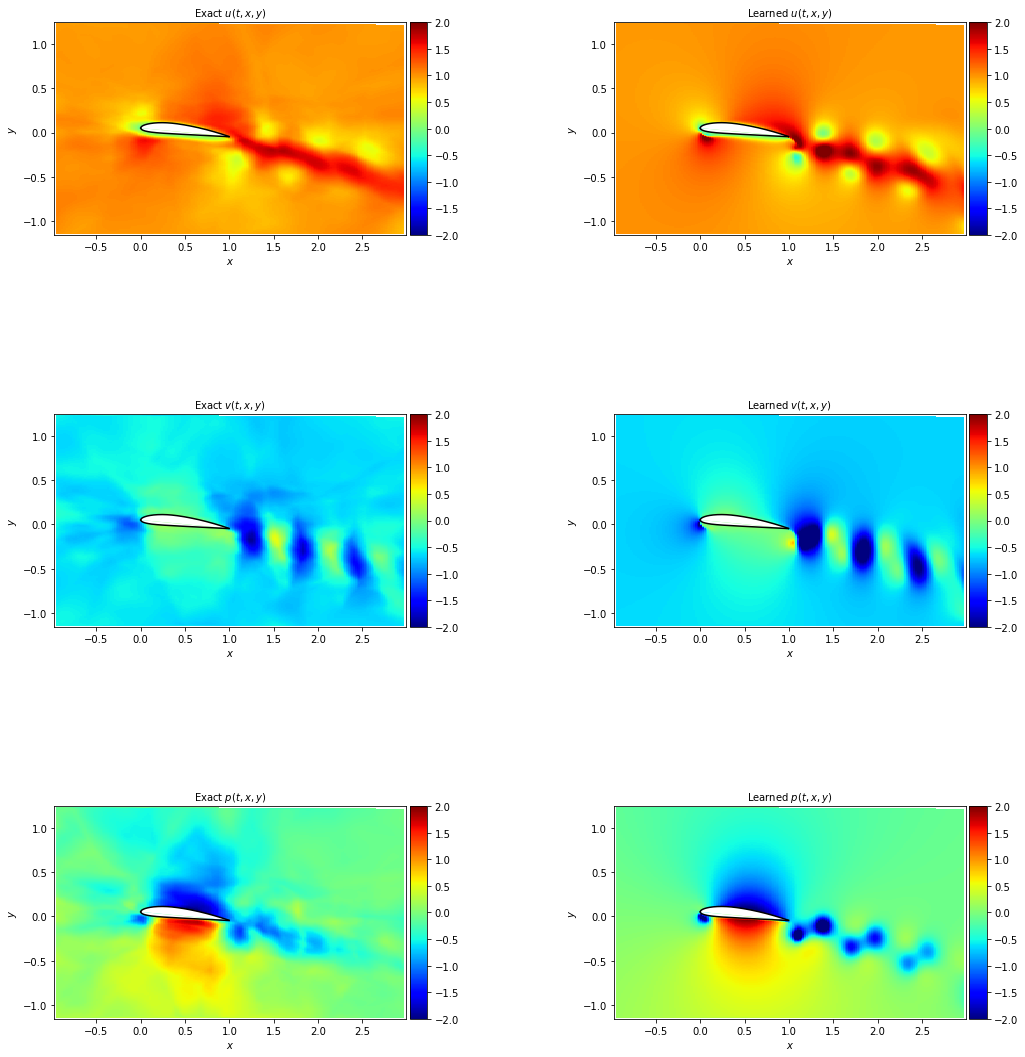

In [17]:
time_snap(2.3,plot=True,print_error=True)

In [ ]:
from tqdm import tqdm
timewise_data = []
time_vals = list(set(data['t']))
time_vals.sort()
# print(time_vals)
for time in tqdm(time_vals):
    eta_val = ((data[data['t']==time]).sample(1))['eta'].iloc[0]
    rmse_u,rmse_v,rmse_p,eta_pred = time_snap(time)
    time_data = np.array([time,rmse_u,rmse_v,rmse_p,eta_pred,eta_val])
#     print(time_data)
    timewise_data.append(time_data)
    
timewise_data = np.array(timewise_data)

In [ ]:
# eta_pred_deS = []
# print(scaler.data_range_)
# for eta_pred in eta_preds:
#     eta = eta_pred*scaler.data_range_[6]+scaler.min_[6]
#     eta_pred_deS.append(eta)
timewise_data.shape

In [ ]:
times,u_rmses,v_rmses,p_rmses,eta_preds,eta_vals = np.split(timewise_data,6,axis=1)
plt.plot(times,eta_vals,'bo')
plt.plot(times,eta_preds,'g-')
plt.ylabel('eta')
plt.xlabel('time')
plt.show()

In [ ]:
plt.plot(times,u_rmses)
plt.ylabel('rmse_u')
plt.xlabel('time')
plt.show()

In [ ]:
plt.plot(times,v_rmses)
plt.ylabel('rmse_v')
plt.xlabel('time')
plt.show()

In [ ]:
plt.plot(times,p_rmses)
plt.ylabel('rmse_p')
plt.xlabel('time')
plt.show()

In [17]:
import sympy as sp
def drag_lift_fn(nx,ny,R):
    d_lift = sp.Function('F_L')
    d_drag = sp.Function('F_D')

    Re,p,n_x,n_y,u_x,u_y,v_x,v_y,x,y = sp.symbols('Re,p,n_x,n_y,u_x,u_y,v_x,v_y,x,y')
    ds = sp.Function('ds')(x,y)

    d_drag = -p*n_x+2*u_x*n_x/Re+(u_y+v_x)*n_y/Re #sp.integrate(-p*n_x+2*u_x*n_x/Re+(u_y+v_x)*n_y/Re,ds)
    d_lift = -p*n_y+2*v_y*n_y/Re+(u_y+v_x)*n_x/Re #sp.integrate(-p*n_y+2*v_y*n_y/Re+(u_y+v_x)*n_x/Re,ds)

    display(d_drag)
    display(d_lift)
    return d_drag.subs([(Re,R),(n_x,nx),(n_y,ny)]),d_lift.subs([(Re,R),(n_x,nx),(n_y,ny)])

In [18]:
drag_lift_fn(1,1,1000)

-n_x*p + 2*n_x*u_x/Re + n_y*(u_y + v_x)/Re

-n_y*p + n_x*(u_y + v_x)/Re + 2*n_y*v_y/Re

(-p + u_x/500 + u_y/1000 + v_x/1000, -p + u_y/1000 + v_x/1000 + v_y/500)

In [45]:
import sympy as sp
def calc_lift_drag(time,scaler,model,Re=1000):
    point_count=500  
    x_vals = (np.linspace(-0.25,1.25,point_count)).reshape(500,1)
    y_vals = (np.linspace(-0.25,0.25,point_count)).reshape(500,1)
    Y_up = np.full((x_vals.shape[0],1),0.25)
    Y_down = np.full((x_vals.shape[0],1),-0.25)
    X_left = np.full((y_vals.shape[0],1),-0.25)
    X_right = np.full((y_vals.shape[0],1),1.25)
    t_test = np.full((point_count,1),time)
    u_test = np.full((point_count,1),0)
    v_test = np.full((point_count,1),0)
    p_test = np.full((point_count,1),0)
    eta_test = np.full((point_count,1),0)
    
    ## Scale data
    t,x1,y1,u,v,p,eta = scale(t_test,x_vals,Y_up,u_test,v_test,p_test,eta_test)
    t,x2,y2,u,v,p,eta = scale(t_test,X_right,y_vals,u_test,v_test,p_test,eta_test)
    t,x3,y3,u,v,p,eta = scale(t_test,x_vals,Y_down,u_test,v_test,p_test,eta_test)
    t,x4,y4,u,v,p,eta = scale(t_test,X_left,y_vals,u_test,v_test,p_test,eta_test)
    
    def predict_with_grad(t,x,y,model=model,scaler=scaler):
        with tf.GradientTape(persistent=True) as g:
            t_test,x_test,y_test,u,v,p,eta = scale(t,x,y,u_test,v_test,p_test,eta_test)
            t_test_1 = tf.convert_to_tensor(t_test, dtype=tf.float32)
            x_test_1 = tf.convert_to_tensor(x_test, dtype=tf.float32)
            y_test_1 = tf.convert_to_tensor(y_test, dtype=tf.float32)
            uvpEta = model([t_test_1,x_test_1,y_test_1])
            print(uvpEta)
            uvpEta_test = K.eval(uvpEta) #tf.make_ndarray(uvpEta)
            print(uvpEta_test)
            t_pred,x_pred,y_pred,u_pred,v_pred,p_pred,eta_pred = de_scale(t_test,x_test,y_test,uvpEta_test)
#         print(u_pred)
        du_dx,dv_dx,dp_dx,dEta_dx = g.gradient(uvpEta,x_test_1,unconnected_gradients=tf.UnconnectedGradients.NONE)
        du_dy = g.gradient(u_pred,y,unconnected_gradients=tf.UnconnectedGradients.NONE)
        dv_dx = g.gradient(v_pred,x,unconnected_gradients=tf.UnconnectedGradients.NONE)
        dv_dy = g.gradient(v_pred,y,unconnected_gradients=tf.UnconnectedGradients.NONE)
        return du_dx,du_dy,dv_dx,dv_dy
    
    def line1(t,x,y):
        d_drag,d_lift = drag_lift_fn(nx=0,ny=1,R=1000)
#         print(d_drag,d_lift)
        du_dx,du_dy,dv_dx,dv_dy = predict_with_grad(t,x,y)
        print(du_dx.shape,du_dy.shape,dv_dx.shape,dv_dy.shape)
        
    
    plt.plot(x_vals,Y_up)
    plt.plot(x_vals,Y_down)
    plt.plot(X_left,y_vals)
    plt.plot(X_right,y_vals)
    line1(x1,y1,t)

-n_x*p + 2*n_x*u_x/Re + n_y*(u_y + v_x)/Re

-n_y*p + n_x*(u_y + v_x)/Re + 2*n_y*v_y/Re

Tensor("model_1_12/concatenate_2/concat:0", shape=(500, 4), dtype=float32)
[[-3.7176125e-02  1.1025260e-01  8.9107960e-01 -4.7170305e-01]
 [-3.7901681e-02  1.1017965e-01  8.9097357e-01 -4.6955577e-01]
 [-3.8579170e-02  1.1016762e-01  8.9085096e-01 -4.6740296e-01]
 ...
 [-1.1811249e-03 -2.0703746e-01  8.0800539e-01  7.0849496e-01]
 [-7.7372772e-04 -2.0714682e-01  8.0790597e-01  7.0964676e-01]
 [-3.6698574e-04 -2.0725453e-01  8.0780679e-01  7.1079487e-01]]


NotImplementedError: tf.GradientTape.gradients() does not support graph control flow operations like tf.cond or tf.while at this time. Use tf.gradients() instead. If you need this feature, please file a feature request at https://github.com/tensorflow/tensorflow/issues/new

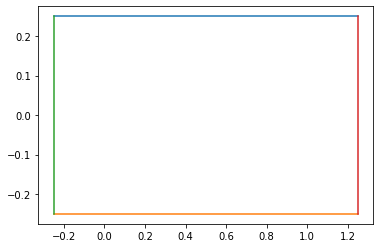

In [46]:
calc_lift_drag(1.25,scaler,model)